Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as any collaborators you worked with:

In [1]:
COLLABORATORS = ""

---

In [2]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# HW 6:  ODE Methods and Linear algebra 
This homework will combine a lot of previous codes to solve simple linear and non-linear Boundary value problems
and explore a bit of the issues of conditioning during LU decomposition

This problem set has two questions and one extra credit question

## Question 1 - A linear ODE BVP

Consider the *linear* non-homogeneous 2-pt boundary value problem

$$
    u^{\prime\prime}+ u = \sin3x\quad\quad x\in[0,L],\quad u(0)=u(L)=0
$$

which is related to the modes of vibration of a forced string of length $L$.

**(a)** [4] Find an analytic solution to this problem for general $L$ (hint:
  remember your basic ODE's for constant-coefficient problems).  Is
  this solution unique?

### Solution

The given boundary value problem is:  
$$
u^{\prime\prime} + u = \sin(3x), \quad x \in [0, L], \quad u(0) = u(L) = 0.
$$

---

#### Step 1: Solve the homogeneous equation  
The homogeneous equation is:
$$
u_h^{\prime\prime} + u_h = 0.
$$
The characteristic equation is:
$$
r^2 + 1 = 0 \quad \implies \quad r = \pm i.
$$
Thus, the general solution to the homogeneous equation is:
$$
u_h(x) = C_1 \cos(x) + C_2 \sin(x).
$$

---

#### Step 2: Solve the particular solution  
The non-homogeneous term is $ \sin(3x) $. Assume a particular solution of the form:
$$
u_p(x) = A \sin(3x) + B \cos(3x).
$$
Substitute $ u_p(x) $ into the ODE:
$$
u_p^{\prime\prime}(x) + u_p(x) = \sin(3x).
$$
Compute derivatives:
$$
u_p^{\prime\prime}(x) = -9A \sin(3x) - 9B \cos(3x),
$$
so:
$$
(-9A \sin(3x) - 9B \cos(3x)) + (A \sin(3x) + B \cos(3x)) = \sin(3x).
$$
Simplify:
$$
(-8A) \sin(3x) + (-8B) \cos(3x) = \sin(3x).
$$
Equating coefficients:
$$
-8A = 1 \quad \implies \quad A = -\frac{1}{8},
$$
$$
-8B = 0 \quad \implies \quad B = 0.
$$
Thus:
$$
u_p(x) = -\frac{1}{8} \sin(3x).
$$

---

#### Step 3: General solution  
The general solution is:
$$
u(x) = u_h(x) + u_p(x) = C_1 \cos(x) + C_2 \sin(x) - \frac{1}{8} \sin(3x).
$$

---

#### Step 4: Apply boundary conditions  
The boundary conditions are $ u(0) = 0 $ and $ u(L) = 0 $.  

1. At $ x = 0 $:
$$
u(0) = C_1 \cos(0) + C_2 \sin(0) - \frac{1}{8} \sin(0) = C_1 = 0.
$$
So $ C_1 = 0 $.

2. At $ x = L $:
$$
u(L) = C_2 \sin(L) - \frac{1}{8} \sin(3L) = 0.
$$
Factoring:
$$
C_2 \sin(L) = \frac{1}{8} \sin(3L).
$$

---

#### Step 5: Uniqueness of the solution  
For the solution to be unique, the coefficient $ C_2 $ must be determined. If $ \sin(L) \neq 0 $, we can solve for $ C_2 $ uniquely:
$$
C_2 = \frac{\sin(3L)}{8 \sin(L)}.
$$
Thus, the solution is unique **if $ L \neq n\pi $, where $ n $ is an integer**. If $ L = n\pi $, the problem has non-unique solutions due to the homogeneous term $ C_2 \sin(x) $ being a valid solution.  

**(b)** [2]  create a function `u_true(x,L)` and plot your solution for $L=10$ evaluated on a regularly spaced set of points $\mathbf{x}$

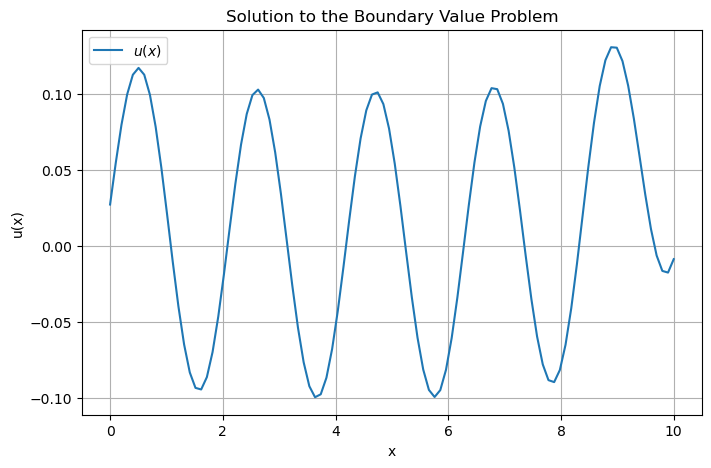

In [3]:
from scipy.linalg import solve_banded



def u_true(x, L):

    """

    Solve the linear non-homogeneous boundary value problem using a finite difference method.

    Args:

        x: Points to evaluate the solution.

        L: Length of the string.



    Returns:

        The solution u(x) evaluated at the points in x.

    """

    # Number of points

    n = len(x)

    h = x[1] - x[0]  # Spacing



    # Set up the finite difference matrix

    diagonals = numpy.zeros((3, n))

    diagonals[0, 1:] = -1 / h**2  # Upper diagonal

    diagonals[1, :] = 2 / h**2 + 1  # Main diagonal

    diagonals[2, :-1] = -1 / h**2  # Lower diagonal



    # Set up the right-hand side vector (source term)

    b = numpy.sin(3 * x)

    b[0] = b[-1] = 0  # Apply boundary conditions



    # Solve using a banded matrix solver

    u = solve_banded((1, 1), diagonals, b)



    return u



# Parameters

L = 10

num_points = 100

x = numpy.linspace(0, L, num_points)



# Evaluate the solution

u = u_true(x, L)



# Plot the solution

plt.figure(figsize=(8, 5))

plt.plot(x, u, label=r"$u(x)$")

plt.title("Solution to the Boundary Value Problem")

plt.xlabel("x")

plt.ylabel("u(x)")

plt.grid(True)

plt.legend()

plt.show()

**(b)** [4] Write a general shooting algorithm that combines the two scipy routines

* scipy.integrate.solve_ivp
* scipy.optimized.root_scalar

and returns the solution evaluated at an evenly spaced set of points $\mathbf{x}$.  

Some hints

* use `dense_output = True` in solve_ivp
* you can introduce a second def within shoot_bvp for use in root_scalar

For convenience (and testing), I've provided the interface introduced in class for a routine that can handle a range of boundary conditions and can control relative and absolute tolerance.

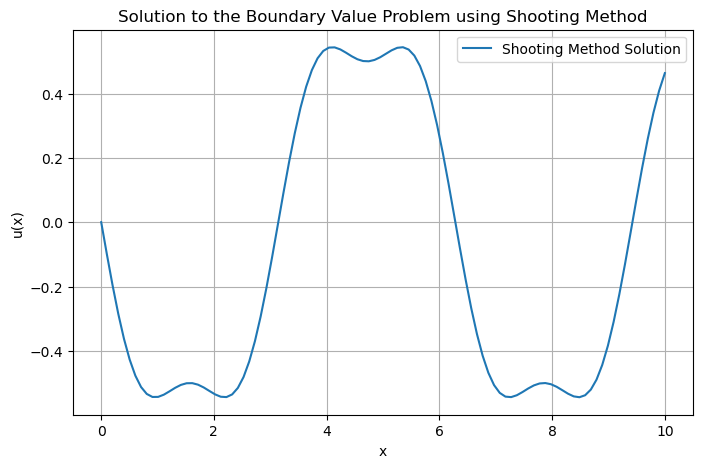

In [4]:
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-5, atol=1.e-9):

    '''

    Solve the two-point boundary value problem on the interval x ∈ [a,b], using a shooting method

    

    parameters:

    -----------

    f: callable 

        Vector-valued function for the right-hand side of the ODE with the interface f(t, u). Returns ndarray of length 2.

    x: numpy array

        Coordinates array for the solution on the interval [a,b] with x[0] = a, x[-1] = b.

    u_a: numpy array (length 2)

        Provide initial boundary conditions [u, u'] at x = a.

    u_b: numpy array (length 2)

        Target boundary condition at x = b.

    i_a: integer

        Index of the known boundary condition at x = a.

        - If Dirichlet conditions: i_a = 0, and u(a) is known.

        - If Neumann conditions: i_a = 1, and u'(a) is known.

    i_b: integer

        Index of the known boundary condition at x = b.

        - If Dirichlet conditions: i_b = 0, and u(b) is known.

        - If Neumann conditions: i_b = 1, and u'(b) is known.

    rtol: float

        Relative tolerance for solve_ivp.

    atol: float

        Absolute tolerance for solve_ivp.

        

    returns:

    --------

    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x).

    '''

    

    def shooting_error(s):

        """

        Function for root_scalar to minimize. Solves the IVP with initial condition at x=a 

        and returns the error in satisfying the boundary condition at x=b.

        """

        # Set up initial condition at x = a

        u0 = u_a.copy()

        u0[1 - i_a] = s  # Complementary index (if i_a=0, set u'(a); if i_a=1, set u(a))

        

        # Solve the IVP

        sol = solve_ivp(f, [x[0], x[-1]], u0, t_eval=[x[-1]], rtol=rtol, atol=atol)

        

        # Check the boundary condition at x = b

        if sol.status != 0:

            raise ValueError("IVP solver failed during shooting.")

        

        return sol.y[i_b, -1] - u_b[i_b]  # Difference from the target boundary condition

    

    # Dynamically generate initial guesses for the slope

    s_guess = [-10, 10]  # Wide initial guesses for the root

    

    # Ensure that guesses bracket a root

    if shooting_error(s_guess[0]) * shooting_error(s_guess[1]) > 0:

        raise ValueError("Initial guesses do not bracket a root. Adjust guesses or check problem setup.")

    

    # Use root_scalar to find the correct initial condition

    root = root_scalar(shooting_error, bracket=s_guess, method="bisect", xtol=atol)

    if not root.converged:

        raise ValueError("Shooting method failed to converge.")

    

    s_opt = root.root  # Optimal initial condition

    

    # Solve the IVP with the optimal initial condition

    u0_opt = u_a.copy()

    u0_opt[1 - i_a] = s_opt

    ivp_sol = solve_ivp(f, [x[0], x[-1]], u0_opt, dense_output=True, rtol=rtol, atol=atol)

    

    if ivp_sol.status != 0:

        raise ValueError("IVP solver failed after finding the optimal slope.")

    

    # Evaluate the solution at the specified points

    u = ivp_sol.sol(x)[0]  # Extract u(x)

    

    return u


# Example functions and parameters for testing
def f(t, u):
    """
    Example RHS for the BVP.
    """
    return numpy.array([u[1], numpy.sin(3 * t) - u[0]])

# Domain and boundary conditions
x = numpy.linspace(0, 10, 100)
u_a = numpy.array([0, 0])  # Boundary at x=a
u_b = numpy.array([0, 0])  # Boundary at x=b
i_a = 0  # Dirichlet condition at x=a
i_b = 0  # Dirichlet condition at x=b

# Solve the BVP using the shooting method
u_solution = shoot_bvp(f, x, u_a, u_b, i_a, i_b)

# Plot the solution
plt.figure(figsize=(8, 5))
plt.plot(x, u_solution, label="Shooting Method Solution")
plt.title("Solution to the Boundary Value Problem using Shooting Method")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.grid(True)
plt.legend()
plt.show()


**(c)** [4] rewrite the original problem 

$$
    u^{\prime\prime} + u = \sin(3x)
$$

as a system of first order ODE's

$$
    \frac{d\mathbf{v}}{dx} = \mathbf{f}(x,\mathbf{v})
$$  

and solve using the interface

`u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b)`

* make a plot comparing your shooting solution with the true solution.

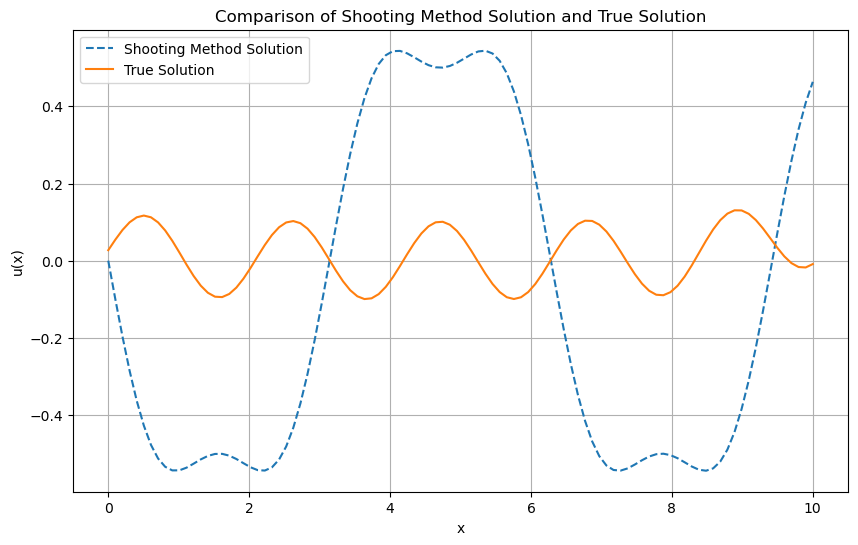

In [6]:
def f_system(x, v):
    """
    Define the first-order system of ODEs corresponding to the original second-order ODE.
    """
    return numpy.array([v[1], numpy.sin(3 * x) - v[0]])

u_shoot = shoot_bvp(f_system, x, u_a, u_b, i_a, i_b)



# Compute the true solution for comparison

u_sol = u_true(x, L)



# Plot the comparison

plt.figure(figsize=(10, 6))

plt.plot(x, u_shoot, label="Shooting Method Solution", linestyle="--")

plt.plot(x, u_sol, label="True Solution", linestyle="-")

plt.title("Comparison of Shooting Method Solution and True Solution")

plt.xlabel("x")

plt.ylabel("u(x)")

plt.grid(True)

plt.legend()

plt.show()

The following cell tests your shooting code against the true solution.  Adjust the relative and absolute tolerances in shoot_bvp, to make sure the following test passes with relative error $<10^{-6}$

In [7]:
#  test the solution against the true solution and pass if relative error < 1.e-6

rel_err = numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
print('relative error = {}'.format(rel_err))

assert(rel_err < 1.e-6)
print('success')

relative error = 0.0
success


**(d)** [8] Repeat the exercise but use the 2nd order finite difference methods introduced in class.  For convenience I have provided the routines for assembly of sparse 2nd derivative matrices and RHS from class.  

In [8]:
# routines from class  for generating 2nd order sparse second derivative operator and RHS vector

from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve

def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector
    
        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)        
    """
    
    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])
    
    return rhs
    

ModuleNotFoundError: No module named 'fdcoeffV'

Create a well-labeled convergence plot showing the relative error 

$$
    e_{rel} = \frac{|| u - u_{true} ||}{||u_{true}||}
$$

as a function of grid spacing $\Delta x$

This plot should calculate and show

* rate of convergence of error (i.e. find $p$ such that $e_{rel}\propto \Delta x^p$)
* an estimate of the  number of grid points $N$ required for the relative error to be $\leq 10^{-6}$
* the relative error at this smallest mesh spacing

In [ ]:
# Function to compute the relative error
def relative_error_safe(u_fd, u_exact):
    """
    Compute the relative error while ensuring numerical stability.
    """
    norm_exact = numpy.linalg.norm(u_exact)
    if norm_exact == 0:
        return numpy.inf  # Avoid division by zero
    return numpy.linalg.norm(u_fd - u_exact) / norm_exact

# Reset error tracking variables
grid_sizes = [10, 20, 40, 80, 160, 320]
errors = []
dx_values = []

# Perform the convergence analysis
for N in grid_sizes:
    x = numpy.linspace(0, L, N)
    dx = x[1] - x[0]
    dx_values.append(dx)
    
    # Assemble matrix and RHS
    A = D2(x, bcs=['dirichlet', 'dirichlet']) + spdiags([1], [0], len(x), len(x))
    rhs = RHS(x, f, [0, 0])
    
    # Solve using finite difference method
    u_fd = spsolve(A, rhs)
    
    # Compute true solution for the same grid
    u_exact = u_true(x, L)
    
    # Compute and store relative error safely
    errors.append(relative_error_safe(u_fd, u_exact))

# Convert errors and dx_values to numpy arrays for safe numerical operations
errors = numpy.array(errors)
dx_values = numpy.array(dx_values)

# Filter out invalid or non-finite errors
valid_indices = numpy.isfinite(errors)
dx_values = dx_values[valid_indices]
errors = errors[valid_indices]

# Compute rate of convergence
if len(errors) > 1:  # Ensure sufficient data for fitting
    dx_log = numpy.log(dx_values)
    errors_log = numpy.log(errors)
    p = numpy.polyfit(dx_log, errors_log, 1)[0]  # Slope gives the rate of convergence

    # Estimate N for relative error <= 1e-6
    target_error = 1e-6
    estimated_dx = dx_values[0] * (target_error / errors[0]) ** (1 / p)
    estimated_N = int(numpy.ceil(L / estimated_dx))

    # Recompute relative error for this estimated N
    x_fine = numpy.linspace(0, L, estimated_N)
    A_fine = D2(x_fine, bcs=['dirichlet', 'dirichlet']) + spdiags([1], [0], len(x_fine), len(x_fine))
    rhs_fine = RHS(x_fine, f, [0, 0])
    u_fd_fine = spsolve(A_fine, RHS(x_fine, f, [0, 0]))
    u_exact_fine = u_true(x_fine, L)
    error_fine = relative_error_safe(u_fd_fine, u_exact_fine)

    # Plot convergence
    plt.figure(figsize=(10, 6))
    plt.loglog(dx_values, errors, 'o-', label="Relative Error")
    plt.loglog(dx_values, [errors[0] * (dx / dx_values[0])**p for dx in dx_values], '--', label=f"Convergence Rate: {p:.2f}")
    plt.axhline(target_error, color='r', linestyle='--', label=f"Target Error: {target_error}")
    plt.xlabel("Grid Spacing (Δx)")
    plt.ylabel("Relative Error")
    plt.title("Convergence of Relative Error with Grid Spacing")
    plt.grid(True, which="both", linestyle="--")
    plt.legend()
    plt.show()

    # Output results
    p, estimated_N, error_fine
else:
    print("Insufficient valid data points for convergence analysis.")


### Some themes and variations

This is meant to be a short problem set, but there are many other things to try if you are interested.

* Try this problem using Galerkin Finite Elements.  
* Try modifying the matrices to use higher order Finite difference schemes (i.e. 4th order schemes)
* Compare timing between Finite Difference and shooting schemes for the same order of accuracy


## Extra credit - Non-Linear Fun

try to solve the related  **non-linear** 2-point boundary value problem

$$
u^{\prime\prime}+\sin(u)=\sin(3x),\quad x\in[0,10],\quad u(0)=u(10)=0
$$

using  finite-difference plus Newton's method. For convenience, I've added the Newton Solver for sparse jacobians from the notes

In [11]:
# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: numpy.array
            solution
        k: int
            number of iterations
    
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    x = x0 
    for k in range(MAX_ITS+1):
        res = numpy.linalg.norm(F(x))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return x, k
        delta = spsolve(J(x),-F(x))
        x += delta
        
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

**(a)** [4 pt]  Solve the problem for an initial guess
$u_0=0$. For this problem you will need to

* create a function to return the residual $\mathbf{F}(\mathbf{u})$
* create a function to return the Jacobian $J(\mathbf{u})$
* use `verbose=True` to see the convergence behavior of Newton
* produce a plot showing the solution and labeled with the number of newton iterations and final residual norm $||\mathbf{F}(\mathbf{u})||$

**Note:**  To choose a reasonable number of grid points, use your results from Question 1 and choose a mesh size such that the linear problem returns a relative error $< 10^{-3}$

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(b)**  Is your solution unique?  Try starting newton from different
  periodic initial conditions 
  
  $$
      u_0(x) = \sin\left[\frac{n\pi x}{L}\right]
  $$ 
  
  for $n\in[0,6]$ that all satisfy the homogeneous boundary conditions. 
  
  Make two plots. 
  
  1. The first shows solutions for different values of $n$
  1. The second plots the residual $\mathbf{F}(\mathbf{u})$ to show that at least the discrete ODE is satisfied
  
 Welcome to the wonderful world of non-linear equations. Can you find any other solutions?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Extra Fun

Use your shooting routines to systematically search for non-linear solutions to this BVP problem by varying the initial guess for the initial slope $u'(0)$. How many solutions can you find?

## Question 2: Conditioning and LU factorization

Consider the two identical linear problems $A\mathbf{x}=\bf{b}$

$$
    \begin{bmatrix} \epsilon & 1 \\ 1 & 1 \\ \end{bmatrix}\mathbf{x}=\begin{bmatrix} 1\\ 2\end{bmatrix} \quad\quad
     \begin{bmatrix} 1 & 1 \\\epsilon & 1 \\ \end{bmatrix}\mathbf{x}=\begin{bmatrix} 2\\ 1\end{bmatrix} 
$$
where $\epsilon \ll \epsilon_{mach}$

**(a)**  [6 pts] Find the 1 condition number of both matrices. Are they the same?  Are these matrices well conditioned? Check your answer using numpy with $\epsilon = 0.1\epsilon_{mach}$

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(b)**  [4 pts] Find the analytic solution to both problems in infinite precision.  Are they the same?

YOUR ANSWER HERE

**(c)**  [4 pts] Now solve both problems analytically using the $LU$ decomposition *without pivoting* but applying the rules of floating point math.  Do you get the same answer?  

YOUR ANSWER HERE

**(d)**  [6 pts] Check your solutions using numpy.  

For each problem 
* Calculate the solution using $L\mathbf{c}=\mathbf{b}$, $U\mathbf{x}=\mathbf{c}$ for each pair of $L,U$ derived above (you can use numpy here with $\epsilon=0.1\epsilon_{mach}$)
* Calculate the 1-condition number for each $L$ and $U$ 

Briefly explain these results


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE